***The purpose is of this notebook to submit my project of Data Mining to practice classifier and feature engineering.****

***The reference for this code is taken from the following:**
1. https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
2. https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


## 1. Import Data

In [2]:
# Import libraries required

import seaborn as sns
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load data files
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission_data = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

print (train_data.shape)
print (test_data.shape)
print (sample_submission_data.shape)

(7613, 5)
(3263, 4)
(3263, 2)


## 2. Refine Data

In [3]:
# Remove duplicate values from train_data

train_data = train_data.drop_duplicates().reset_index(drop=True)

In [4]:
# Check blank values in train_data
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# Check blank values in test_data
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

We can see there are very less blank values for "keyword" and more blank values for "location" in train as well as test data

So, we don't need to replace blank "keyword" and for blank "location" we will check later if it is very much affecting our target.

## 3. Keywords

In [6]:
# Check number of unique "keywords"
print ("Train data unique keywords", train_data.keyword.nunique())
print ("Test data unique keywords", test_data.keyword.nunique())

#We can see the number of unique keywords are same for both datasets

Train data unique keywords 221
Test data unique keywords 221


Find out the Top 20 keywords for disaster and non-disaster

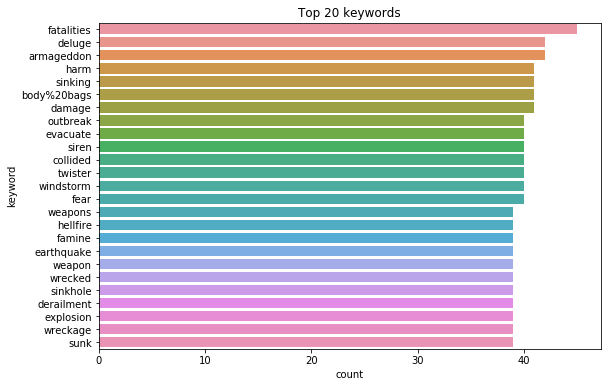

In [7]:
# Most common "keywords"

plt.figure(figsize=(9,6))

sns.countplot(y=train_data.keyword, order = train_data.keyword.value_counts().iloc[:25].index)
plt.title('Top 20 keywords')
plt.show()

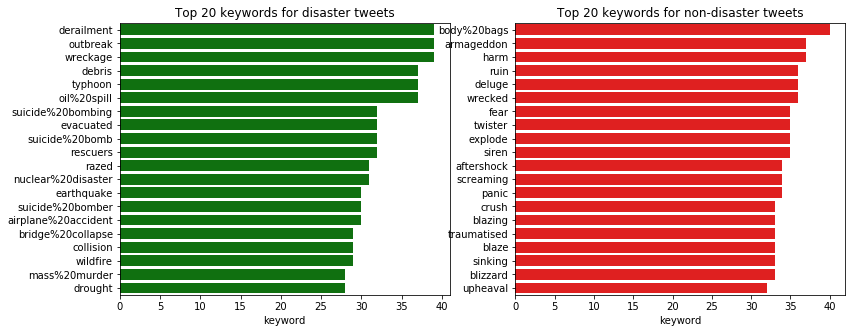

In [8]:
key_d = train_data[train_data.target==1].keyword.value_counts().head(20)
key_nd = train_data[train_data.target==0].keyword.value_counts().head(20)

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(key_d, key_d.index, color='green')
plt.title('Top 20 keywords for disaster tweets')

plt.subplot(122)
sns.barplot(key_nd, key_nd.index, color='red')
plt.title('Top 20 keywords for non-disaster tweets')

plt.show()

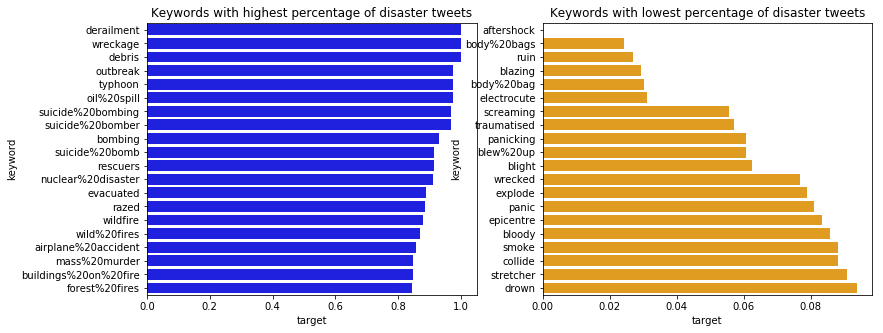

In [9]:
top_key_d = train_data.groupby('keyword').mean()['target'].sort_values(ascending=False).head(20)
top_key_nd = train_data.groupby('keyword').mean()['target'].sort_values().head(20)

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(top_key_d, top_key_d.index, color='blue')
plt.title('Keywords with highest percentage of disaster tweets')

plt.subplot(122)
sns.barplot(top_key_nd, top_key_nd.index, color='orange')
plt.title('Keywords with lowest percentage of disaster tweets')

plt.show()

We didn't find any common values for top-20 disaster adn non-disaster keywords between train_data and test_data

## 4. Locations

In [10]:
# Check number of unique "locations"
print ("Train data unique locations", train_data.location.nunique())
print ("Test data unique locations", test_data.location.nunique())

# We can see the number of unique locations are not same for both datasets

Train data unique locations 3341
Test data unique locations 1602


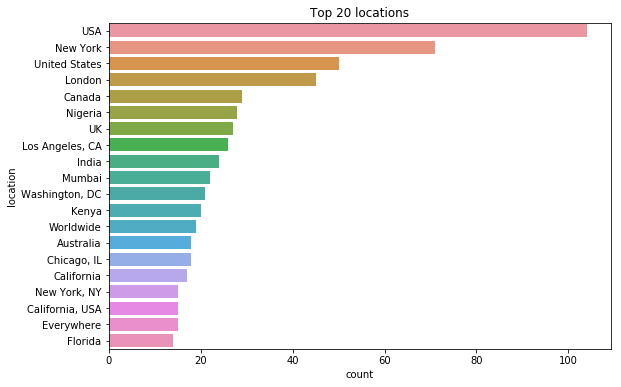

In [11]:
# Top 20 Locations

plt.figure(figsize=(9,6))
sns.countplot(y=train_data.location, order = train_data.location.value_counts().iloc[:20].index)

plt.title('Top 20 locations')
plt.show()

As we can see there are same locations with different names like "USA" and "United States", we can merge them to get cleaner data.
Also we need to check percentage of disaster tweets for these locations.

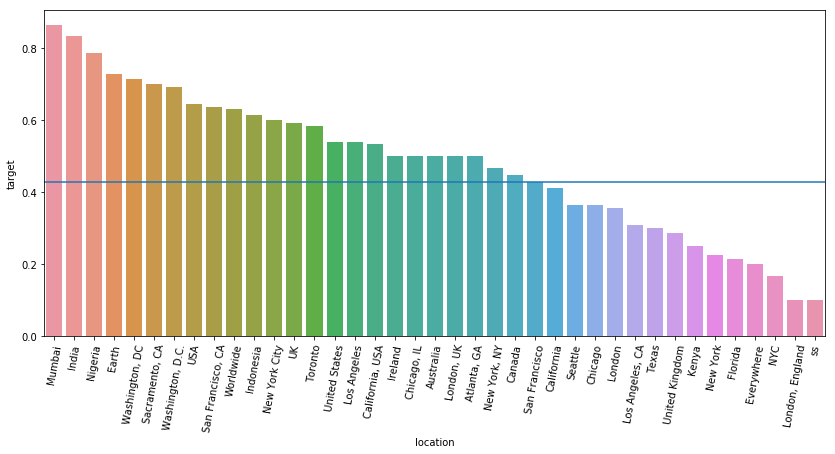

In [12]:
raw_loc = train_data.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_data[train_data.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_data.target))
plt.xticks(rotation=80)
plt.show()

## 5. Clean missing and duplicate values

As we discussed earlier, we need to clean data for further processing as it is going to have a big effect on our resultant target values.

Also, we need to merge the locations with same meaning.
for eg. "USA" and "United States", "New York City" and "NYC", etc

In [13]:
# Re-fill missing values
for col in ['keyword','location']:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')


# Merge locations with same meaning
def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train_data['location_clean'] = train_data['location'].apply(lambda x: clean_loc(str(x)))
test_data['location_clean'] = test_data['location'].apply(lambda x: clean_loc(str(x)))

In [14]:
# Re-check cleaned value for train_data
print(train_data)

         id keyword location  \
0         1    None     None   
1         4    None     None   
2         5    None     None   
3         6    None     None   
4         7    None     None   
...     ...     ...      ...   
7608  10869    None     None   
7609  10870    None     None   
7610  10871    None     None   
7611  10872    None     None   
7612  10873    None     None   

                                                   text  target location_clean  
0     Our Deeds are the Reason of this #earthquake M...       1           None  
1                Forest fire near La Ronge Sask. Canada       1           None  
2     All residents asked to 'shelter in place' are ...       1           None  
3     13,000 people receive #wildfires evacuation or...       1           None  
4     Just got sent this photo from Ruby #Alaska as ...       1           None  
...                                                 ...     ...            ...  
7608  Two giant cranes holding a bridge collapse

In [15]:
# Re-check cleaned value for test_data
print(test_data)

         id keyword location  \
0         0    None     None   
1         2    None     None   
2         3    None     None   
3         9    None     None   
4        11    None     None   
...     ...     ...      ...   
3258  10861    None     None   
3259  10865    None     None   
3260  10868    None     None   
3261  10874    None     None   
3262  10875    None     None   

                                                   text location_clean  
0                    Just happened a terrible car crash           None  
1     Heard about #earthquake is different cities, s...           None  
2     there is a forest fire at spot pond, geese are...           None  
3              Apocalypse lighting. #Spokane #wildfires           None  
4         Typhoon Soudelor kills 28 in China and Taiwan           None  
...                                                 ...            ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...           None  
3259  Storm in RI worse than la

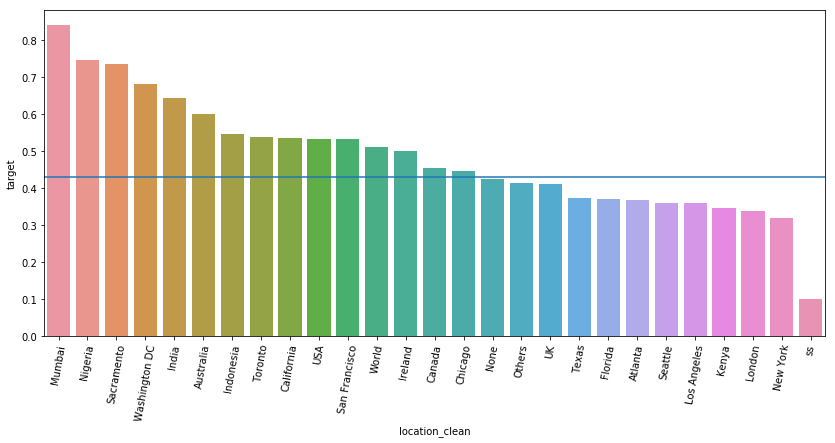

In [16]:
# Plot cleaned location data on graph

top_l2 = train_data.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train_data.target))
plt.xticks(rotation=80)
plt.show()

## 6. Clean text in the columns

Here we clean up the text column by:

Making a 'clean' text column, removing links and unnecessary white spaces
Creating separate columns containing lists of hashtags, mentions, and links

In [17]:
# Cleaning keywords from train_data

import re

for col in train_data['keyword']:
    test_str = col
    def clean_text(text):
        text = re.sub(r'%20+', '_', text) # Replace %20 with Underscore
        
        return text

    # print("Original text: " + test_str)
    # print("Cleaned text: " + clean_text(test_str))

In [18]:
# Cleaning keywords from test_data

import re

for col in test_data['keyword']:
    test_str = col
    def clean_text(text):
        text = re.sub(r'%20+', '_', text) # Replace %20 with Underscore
        
        return text

    # print("Original text: " + test_str)
    # print("Cleaned text: " + clean_text(test_str))

In [19]:
# Cleaning Tweet Text from train_data

import re

for col in train_data['text']:
    test_str = col
    def clean_text(text):
        text = re.sub(r'%20+', ' ', text) # Replace %20 with Space
        text = re.sub(r'&amp;+', '&', text) # Replace &amp with "&" symbol
        text = re.sub(r'https?://\S+', '', text) # Remove link
        text = re.sub(r'\n',' ', text) # Remove line breaks
        text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
        return text

    # print("Original tweet: " + test_str)
    # print("Cleaned tweet: " + clean_text(test_str))

In [20]:
# Cleaning Tweet Text from test_data

import re

for col in test_data['text']:
    test_str = col
    def clean_text(text):
        text = re.sub(r'%20+', ' ', text) # Replace %20 with Space
        text = re.sub(r'&amp;+', '&', text) # Replace &amp with "&" symbol
        text = re.sub(r'https?://\S+', '', text) # Remove link
        text = re.sub(r'\n',' ', text) # Remove line breaks
        text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
        return text

    # print("Original tweet: " + test_str)
    # print("Cleaned tweet: " + clean_text(test_str))

In [21]:
# Categorizing data based on hashtags, mentions, and links for both train_data & test_data

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    
    return df
    
train_data = process_text(train_data)
test_data = process_text(test_data)

## 7. Perform more refinement 
## (based on Stopwords, Punctuation, etc.)

In [22]:
# Check for all stopwords, punctuations, etc. from the cleaned data

from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train_data = create_stat(train_data)
test_data = create_stat(test_data)

print(train_data.shape, test_data.shape)

(7613, 19) (3263, 18)


In [23]:
# Sort and find out the correlation of all "counts" with "target"

train_data.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.015179
punctuation_count   -0.011551
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.097353
Name: target, dtype: float64

## 8. Use Refined Data for Target Encoding

Applying Feature Engineering:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [24]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train_data[features],train_data['target'])

train_data = train_data.join(encoder.transform(train_data[features]).add_suffix('_target'))
test_data = test_data.join(encoder.transform(test_data[features]).add_suffix('_target'))

In [25]:
# Vectorize the cleaned text

from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train_data['links'])
link_vec_test = vec_links.transform(test_data['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train_data['mentions'])
men_vec_test = vec_men.transform(test_data['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train_data['hashtags'])
hash_vec_test = vec_hash.transform(test_data['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())

print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


In [26]:
# Calculate percentage of disaster given by links
_ = (X_train_link.transpose().dot(train_data['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)

In [27]:
# Calculate percentage of disaster given by mentions
_ = (X_train_men.transpose().dot(train_data['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)

In [28]:
# Check hashtags with which 100% of Tweets are disasters
hash_rank = (X_train_hash.transpose().dot(train_data['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))

Hashtags with which 100% of Tweets are disasters: 
['yyc', 'japan', 'science', 'rohingya', 'okwx', 'newyork', 'myanmar', 'mumbai', 'wx', 'libya', 'india', 'socialnews', 'hiroshima', 'hailstorm', 'earthquake', 'disaster', 'breaking', 'bestnaijamade', 'antioch', 'africa', 'sittwe', 'mh370', 'abstorm', 'worldnews', 'wildfire', 'wildfires']
Total: 26


In [29]:
# Check hashtags with which 0% of Tweets are disasters
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 0% of Tweets are disasters: 
['np', 'summerfate', 'job', 'jobs', 'animalrescue', 'kindle', 'fashion', 'bb17', 'dnb', 'ices', 'beyhive', 'edm', 'technology', 'dubstep', 'trapmusic', 'military', 'dance', 'soundcloud']
Total: 18


In [30]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train_data['text_clean'])
text_vec_test = vec_text.transform(test_data['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1690)


In [31]:
# Joining the dataframes together

train_data = train_data.join(X_train_link, rsuffix='_link')
train_data = train_data.join(X_train_men, rsuffix='_mention')
train_data = train_data.join(X_train_hash, rsuffix='_hashtag')
train_data = train_data.join(X_train_text, rsuffix='_text')
test_data = test_data.join(X_test_link, rsuffix='_link')
test_data = test_data.join(X_test_men, rsuffix='_mention')
test_data = test_data.join(X_test_hash, rsuffix='_hashtag')
test_data = test_data.join(X_test_text, rsuffix='_text')
print (train_data.shape, test_data.shape)

(7613, 1842) (3263, 1841)


## 9. Logistic Regression Model

We try the simplest model with logistic regression, based on all features we created above. Before we fit a model, we first transform the features into the same scale with minimum 0 and maximum 1. 

We do this in the form of pipeline.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train_data.drop(columns = features_to_drop + ['target'])
X_test = test_data.drop(columns = features_to_drop)
y_train = train_data.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sample_submission_data.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [33]:
# Check the Training Accuracy
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8534
